In [3]:
# Import packages 

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision
from torchvision.transforms import Compose, ToTensor, RandomHorizontalFlip, ToPILImage, Resize, Normalize
from torchvision.datasets import DatasetFolder
from torch.utils.data import random_split
import core
import numpy as np
import copy
import cv2
from sklearn.metrics.pairwise import cosine_similarity
import my_models
import random
import time
from utils import*

In [4]:
# Loaod a checkpoint
model = my_models.ResNet(18)
chk = torch.load('checkpoints/best_ckpt_IAD.pth')
model.load_state_dict(chk)

<All keys matched successfully>

In [5]:
# Load benign and poisoned data

datasets_root_dir = './data'

dataset = torchvision.datasets.CIFAR10

transform_train = Compose([
    Resize((32, 32)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.485, 0.456, 0.406),
                        (0.229, 0.224, 0.225))
])
transform_test = Compose([
    Resize((32, 32)),
    ToTensor(),
    Normalize((0.485, 0.456, 0.406),
                        (0.229, 0.224, 0.225))
])

trainset = dataset(datasets_root_dir, train=True, transform=transform_train, download=True)
testset = dataset(datasets_root_dir, train=False, transform=transform_test, download=True)

poisoned_testset = torch.load('./data/poisoned_testsets/poisoned_CIFAR10_IAD.t7')
target_class = 1

Files already downloaded and verified
Files already downloaded and verified


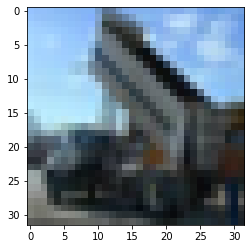

In [6]:
# Show an example of benign data

inv = transforms.Compose([transforms.Normalize(mean = [0., 0., 0. ],
                                                     std = [1/0.229, 1/0.224, 1/0.225]),
                                transforms.Normalize(mean = [-0.485, -0.456, -0.406 ],
                                                     std = [1., 1., 1. ]),
                               ])

img_idx = 50
clean_image, _ = testset[img_idx]
clean_image = inv(clean_image)
plt.imshow(clean_image.permute(1, 2, 0).numpy())

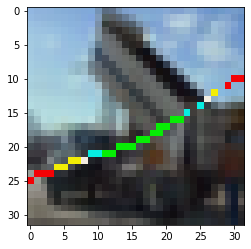

In [7]:
# Show an example of poisoned data

poisoned_image, _ = poisoned_testset[img_idx]
poisoned_image = inv(poisoned_image)
plt.imshow(poisoned_image.permute(1, 2, 0).numpy())

In [8]:
# Sample 10% of the benign test data and extract their intermediate features
t = 0
current_time = time.time()
num_classes = 10
p = 0.1
n = len(testset)
m = int(n * p)
sampleset, _ = random_split(testset, [m, n - m])

sample_ftrs_dict, sample_labels, sample_preds = \
                    get_features(model, sampleset)

t+= time.time() - current_time

In [14]:
# Identify the layer the layer of interest (LOI) for each class
current_time = time.time()
L = len(sample_ftrs_dict.keys())
print('Number of layers:', L)
canditae_layers = []
for c in range(num_classes):
    sim_sample = None
    for l in range(L):
        idxs = np.where(sample_preds == c)[0]
        data = sample_ftrs_dict[l][idxs]
        centroid = data.mean(axis = 0).reshape(1, -1)
        cs = cosine_similarity(data, centroid)
        if sim_sample is None:
            sim_sample = cs
        else:
            sim_sample = np.hstack((sim_sample, cs))
    mean_sim = sim_sample.mean(0)
    h = int(L/2)
    diff_sim = mean_sim[1:L] - mean_sim[0:L-1]
    max_diff_l = h+diff_sim[h:].argmax()+1
    print('Class:{}, Layer of maximum difference:{}'.format(c, max_diff_l+1))
    # Add the three identified layers for each class
    canditae_layers.append(np.arange(max_diff_l - 2, max_diff_l+1))
t+= time.time() - current_time

Number of layers: 10
Class:0, Layer of maximum difference:9
Class:1, Layer of maximum difference:8
Class:2, Layer of maximum difference:9
Class:3, Layer of maximum difference:9
Class:4, Layer of maximum difference:9
Class:5, Layer of maximum difference:9
Class:6, Layer of maximum difference:8
Class:7, Layer of maximum difference:9
Class:8, Layer of maximum difference:9
Class:9, Layer of maximum difference:8


In [16]:
# Exatrct the features of benign test set
test_ftrs_dict, test_labels, test_preds = \
                    get_features(model, testset)

# Extract the features of poisoned test set
poisoned_ftrs_dict, poisoned_labels, poisoned_preds = \
                    get_features(model, poisoned_testset)

In [24]:
''' Approximate the distribution of benign samples in the identified layers for each class, 
        and filter out potential poisoned samples'''
current_time = time.time()

# Use different thresholds
taus = [0.5, 1, 1.5, 2, 2.5, 3]

# Use recommended threshold = 2.5
# taus = [2.5]
gt, pred = None, None
num_exper = 5
for tau in taus:
    tprs, fprs = [], []
    print('Tau:{}'.format(tau))
    for i in range(num_exper):
        gt, pred = None, None
        for c in range(num_classes):
#             if c != target_class:continue
            idxs = np.where(test_labels == c)[0]
            k = len(idxs)
        
            # Sample 10% from the benign features of the target class
            idxs = np.random.choice(idxs, int(k*0.1), replace = False)
            idxs_samples = idxs

            sim_sample = None
            sim_test = None
            sim_poisoned = None
            
            # Select samples classified into the potential target class by the attacked model
            idxs_test = np.where(test_preds == c)[0]
            idxs_poisoned = np.where((poisoned_preds == c) & (test_labels != c))[0]

            # Approximate the summed cosine similarities (sample-wise) for each class.
            for l in canditae_layers[c]:
                sample_data = test_ftrs_dict[l][idxs_samples]
                test_data = test_ftrs_dict[l][idxs_test]
                poisoned_data = poisoned_ftrs_dict[l][idxs_poisoned]
                layer_centroid = np.mean(sample_data, axis = 0).reshape(1, -1)
                cs_sample = cosine_similarity(sample_data, layer_centroid)*diff_sim[l]
                cs_test = cosine_similarity(test_data, layer_centroid)*diff_sim[l]
                f = 0
                try:
                    cs_poisoned = cosine_similarity(poisoned_data, layer_centroid)*diff_sim[l]
                except:
                    cs_poisoned = 0
                    f = 1

                if sim_sample is None:
                    sim_sample = cs_sample
                    sim_test = cs_test
                    sim_poisoned = cs_poisoned
                else:
                    sim_sample+= cs_sample
                    sim_test+= cs_test
                    sim_poisoned+= cs_poisoned
            
            # Identity potential poisoned samples
            if gt is None:
                gt = np.array([0]*len(test_data)).reshape(-1, 1) 
            else:
                gt= np.concatenate((gt, np.array([0]*len(test_data)).reshape(-1, 1)))
            u, s = sim_sample.mean(),  sim_sample.std()
            threshold = u - tau*s
            pred_test = (sim_test<threshold) + 0
            if pred is None:
                pred = pred_test
            else:
                pred= np.concatenate((pred, pred_test))

            if c == target_class:
                gt= np.concatenate((gt, np.array([1]*len(poisoned_data)).reshape(-1, 1) ))
                pred_poisoned = (sim_poisoned<threshold) + 0
                pred= np.concatenate((pred, pred_poisoned))

        tp = ((gt + pred) == 2).sum()
        tn = ((gt + pred) == 0).sum()
        fp = ((pred - gt) == 1).sum()
        fn = ((gt - pred) == 1).sum()
        tpr = tp/(tp + fn)*100
        fpr = fp/(fp + tn)*100
        tprs.append(tpr)
        fprs.append(fpr)     
    
    print('TPR:{:0.2f}, FPR:{:0.2f}'.format(np.mean(tprs), np.mean(fprs)))   
    print('TPR-STD:{:0.2f}, FPR-STD:{:0.2f}'.format(np.std(tprs), np.std(fprs)))
    print('---------------------------')
print('Average runtime:{:0.2f}'.format((time.time() - current_time)/(num_exper*len(taus))))

Tau:0.5
TPR:100.00, FPR:33.73
TPR-STD:0.00, FPR-STD:0.94
---------------------------
Tau:1
TPR:99.99, FPR:19.41
TPR-STD:0.01, FPR-STD:0.88
---------------------------
Tau:1.5
TPR:99.87, FPR:9.00
TPR-STD:0.04, FPR-STD:0.59
---------------------------
Tau:2
TPR:99.74, FPR:3.42
TPR-STD:0.10, FPR-STD:0.51
---------------------------
Tau:2.5
TPR:99.46, FPR:1.22
TPR-STD:0.18, FPR-STD:0.32
---------------------------
Tau:3
TPR:95.28, FPR:0.24
TPR-STD:1.79, FPR-STD:0.08
---------------------------
Average runtime:3.00
